In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, unit_det, fit_psi_params, psi_params, ellipse_aspect_ratio

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None


In [2]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept
    

In [3]:
width=500
x = np.linspace(-width // 2, width // 2, 501)
y = np.linspace(-width // 2, width // 2, 501)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0.0, 0.0
Q11, Q12, Q22 = 1, .4, 1
psi0 = 250.0 
Rc = 85.0 
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

dx, dy = X - xc, Y - yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2


,xc,yc,w,q11,q12,q22,Rc,psi0,A
Control,0.000000,0.000000,-2.306805e-07,1.666667,1.333333,1.666667,85.000000,250.000000,-0.034602
P1,-0.037118,-0.037118,-1.478279e-07,1.090459,0.434858,1.090459,85.165271,250.773787,-0.034575
P2,0.333537,-0.333537,-1.383209e-07,1.092562,0.440105,1.092562,85.947038,253.524256,-0.034321
P3,-1.096900,-1.096900,-1.630701e-07,1.093466,0.442343,1.093466,81.848619,241.778103,-0.036091
L1,-0.013042,-0.013042,-1.490516e-07,1.091045,0.436324,1.091045,85.177908,250.775001,-0.034565
L2,-0.037118,-0.037118,-1.478279e-07,1.090459,0.434858,1.090459,85.165271,250.773787,-0.034575
L3,-0.045828,-0.045828,-1.460032e-07,1.089711,0.432979,1.089711,85.105935,250.760398,-0.034621


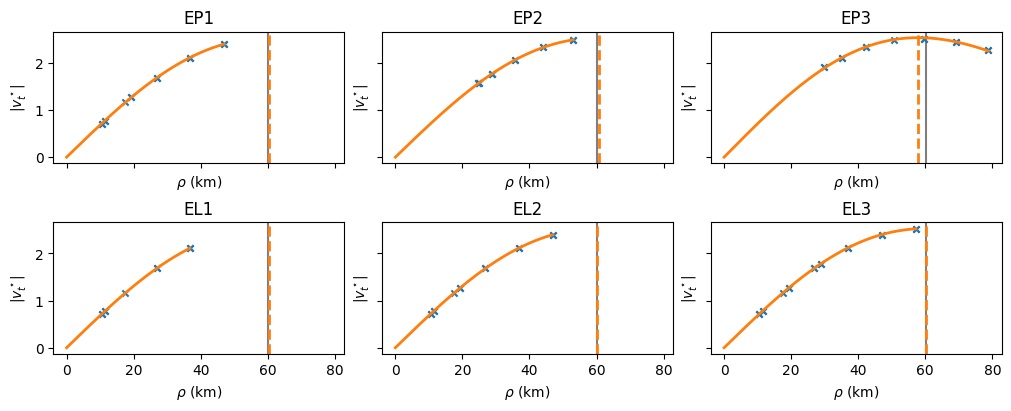

In [21]:
df_res = pd.DataFrame({'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-6], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

nic, njc = 52, 52
r = 6

df_tests = pd.DataFrame({
    'nic': [nic, 45, 44, nic, nic, nic],
    'njc': [njc, 55, 44, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

df_tests = df_tests*5

fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 4), sharey=True, sharex=True)
axs = axs.flatten()

dic_tests = {}
skip = 10
for t, test in enumerate(df_tests.index):
    data = df_tests.loc[test]

    x1 = x[data.nic-data.r:data.nic+data.r+1:skip]
    y1 = np.array([y[data.njc]] * len(x1))

    u1 = u[data.nic-data.r:data.nic+data.r+1:skip, data.njc]
    v1 = v[data.nic-data.r:data.nic+data.r+1:skip, data.njc]

    y2 = y[data.njc-data.r:data.njc+data.r+1:skip]
    x2 = np.array([x[data.nic]] * len(y2))

    u2 = u[data.nic, data.njc-data.r:data.njc+data.r+1:skip]
    v2 = v[data.nic, data.njc-data.r:data.njc+data.r+1:skip]

    points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
    common_points = points1 & points2
    # Remove duplicates from (x1, y1, u1, v1)
    mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
    x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
    # Concatenate with unaltered second set
    xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
    ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

    xc_dop, yc_dop, w_dop, Q_dop, Rc_dop, psi0_dop, A_dop = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, plot_flag=False)
    w_dop *= 1e-6
    
    df = psi_params(xc_dop, yc_dop, Q_dop, xi, yi, ui, vi)
    fit_psi_params(df.rho2, df.Qr, df.vt, r2_flag=True, 
                                     plot=True, Rc_max=1e6, ax=axs[t]) 
    
    dic_tests[test] = {'x1': x1, 'y1': y1, 'u1': u1, 'v1': v1,
                       'x2': x2, 'y2': y2, 'u2': u2, 'v2': v2,
                       'name': test}
    df_res.loc[len(df_res)] = {'xc': xc_dop, 'yc': yc_dop, 'w': w_dop,
                               'q11': Q_dop[0,0], 'q12': Q_dop[0,1], 'q22': Q_dop[1,1],
                               'Rc': Rc_dop, 'psi0': psi0_dop, 'A': A_dop}

for a, ax in enumerate(axs):
    # if a%2==0:
    ax.set_title('E'+df_tests.index[a])
    ax.set_xlabel(r'$\rho$ (km)')
    ax.axvline(Rc/np.sqrt(2), color='k', zorder=-1, alpha=.5)

df_res.index = ['Control'] + list(df_tests.index)
df_res


In [25]:
x[df_tests.nic], y[df_tests.njc], df_tests.r*(x[1]-x[0])


(array([ 10., -25., -30.,  10.,  10.,  10.]),
 array([ 10.,  25., -30.,  10.,  10.,  10.]),
 P1    30.0
 P2    30.0
 P3    30.0
 L1    20.0
 L2    30.0
 L3    40.0
 Name: r, dtype: float64)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


-0.07391396167122072
-0.06916043392768854
-0.08153505446519806


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


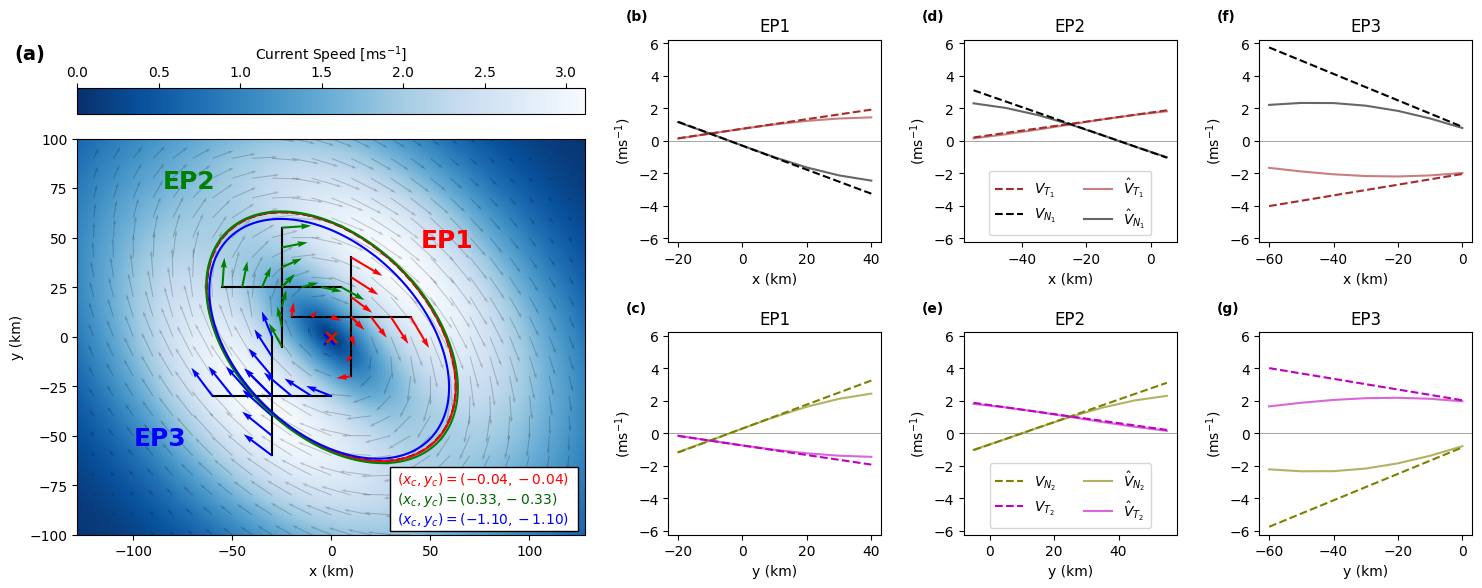

In [5]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'Blues_r'
spacing, scale, width = 2*5, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='Current Speed [ms$^{-1}$]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

ax_main.contour(X, Y, rho2, levels=[Rc**2/2],
                     colors='k', linestyles='--')

colours = ['r', 'g', 'b'] # limegreen
color = ['r', 'g', 'b']

i = 0
scales = [40, 58, 65]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res.loc[dic['name']]
 
        ax_main.plot(x1, y1, 'k', zorder=1)
        ax_main.plot(x2, y2, 'k', zorder=1)

        ax_main.quiver(x1, y1, u1, v1, scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2, y2, u2, v2, scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(data.xc, data.yc, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))

        dx_ell, dy_ell = X - data.xc, Y - data.yc
        rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
        ax_main.contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors=colours[i])


        ax_main.text(33, -74 - 10*i, fr'$(x_c,y_c)=({data.xc:.2f},{data.yc:.2f})$', color='darkgreen' if '2' in dic['name'] else colours[i], zorder=11)
        i += 1

x_pos, y_pos = 0.80, 0.09
box_width = 0.37  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black', zorder=10)
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)', 'EP1'), ('(f)','(g)', 'EP3'), ('(d)','(e)', 'EP2')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res.loc[dic['name']]
        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(x1, v1)
        A1, A0 = tang_at_root(x1, u1, root_x)
        B1, B0 = tang_at_root(x1, v1, root_x)
        print(B1)
        p_u1 = A1*x1 + A0
        p_v1 = B1*x1 + B0

        root_y = find_root(y2, u2)
        C1, C0 = tang_at_root(y2, u2, root_y)
        D1, D0 = tang_at_root(y2, v2, root_y)
        p_u2 = C1*y2 + C0
        p_v2 = D1*y2 + D0
    
        ax2.plot(x1, p_u1, linestyle='--', color='brown', label=r'$V_{T_1}$')
        ax2.plot(x1, p_v1, 'k--', label=r'$V_{N_1}$')
        ax2.plot(x1, u1, color='brown', label=r'$\hat{V}_{T_1}$', alpha=.6)#, color=colours[i])
        ax2.plot(x1, v1, 'k', label=r'$\hat{V}_{N_1}$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(ms$^{-1}$)')
        ax2.set_xlabel(r'x (km)')
        if '2' in dic['name']:
            ax2.legend(loc='lower center', ncol=2)
        ax2.set_title(tags[2-j][2])
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])
        
        ax3.plot(y2, p_u2, linestyle='--', color='olive', label=r'$V_{N_2}$')
        ax3.plot(y2, p_v2, 'm--', label=r'$V_{T_2}$')
        ax3.plot(y2, u2, color='olive', label=r'$\hat{V}_{N_2}$', alpha=.6)#, color=colours[i])
        ax3.plot(y2, v2, 'm', label=r'$\hat{V}_{T_2}$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(ms$^{-1}$)')
        ax3.set_xlabel(r'y (km)')
        if '2' in dic['name']:
            ax3.legend(loc='lower center', ncol=2)
        ax3.set_title(tags[2-j][2])
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

ax_main.text(45, 45, 'EP1', color=color[0], zorder=3, fontsize=18, fontweight='bold')
ax_main.text(-85, 75, 'EP2', color=color[1], zorder=3, fontsize=18, fontweight='bold')
ax_main.text(-100, -55, 'EP3', color=color[2], zorder=3, fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()


In [6]:
df_res


,xc,yc,w,q11,q12,q22,Rc,psi0,A
Control,0.000000,0.000000,-1.510158e-07,1.091089,0.436436,1.091089,85.000000,250.000000,-0.034602
P1,-0.037118,-0.037118,-1.478279e-07,1.090459,0.434858,1.090459,85.165271,250.773787,-0.034575
P2,0.333537,-0.333537,-1.383209e-07,1.092562,0.440105,1.092562,85.947038,253.524256,-0.034321
P3,-1.096900,-1.096900,-1.630701e-07,1.093466,0.442343,1.093466,81.848619,241.778103,-0.036091
L1,-0.013042,-0.013042,-1.490516e-07,1.091045,0.436324,1.091045,85.177908,250.775001,-0.034565
L2,-0.037118,-0.037118,-1.478279e-07,1.090459,0.434858,1.090459,85.165271,250.773787,-0.034575
L3,-0.045828,-0.045828,-1.460032e-07,1.089711,0.432979,1.089711,85.105935,250.760398,-0.034621


In [7]:
df_err = (df_res - df_res.iloc[0]).abs().iloc[1:]
df_err.index = ['EP1 Err', 'EP2 Err', 'EP3 Err',
                'EL1 Err', 'EL2 Err', 'EL3 Err']
df_err


,xc,yc,w,q11,q12,q22,Rc,psi0,A
EP1 Err,0.037118,0.037118,3.187918e-09,0.000630,0.001578,0.000630,0.165271,0.773787,0.000027
EP2 Err,0.333537,0.333537,1.269497e-08,0.001473,0.003669,0.001473,0.947038,3.524256,0.000281
EP3 Err,1.096900,1.096900,1.205427e-08,0.002376,0.005907,0.002376,3.151381,8.221897,0.001489
EL1 Err,0.013042,0.013042,1.964256e-09,0.000045,0.000112,0.000045,0.177908,0.775001,0.000038
EL2 Err,0.037118,0.037118,3.187918e-09,0.000630,0.001578,0.000630,0.165271,0.773787,0.000027
EL3 Err,0.045828,0.045828,5.012683e-09,0.001378,0.003457,0.001378,0.105935,0.760398,0.000019


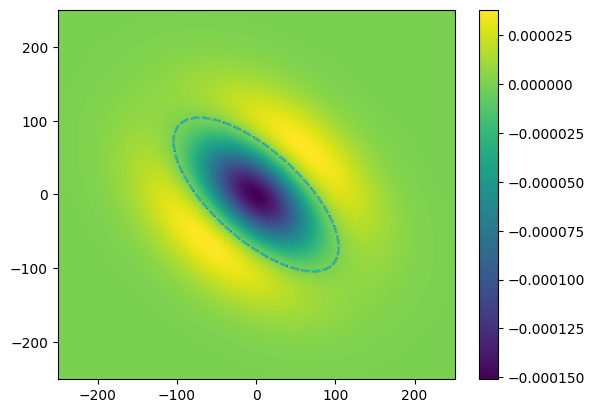

In [8]:
dx = (X[1,0] - X[0,0])*1e3
dy = (Y[0,1] - Y[0,0])*1e3

dv_dx = np.gradient(v, dx, axis=0)
du_dy = np.gradient(u, dy, axis=1)

zeta = dv_dx - du_dy
plt.pcolor(X, Y, zeta)
plt.colorbar()
clrs =['r', 'm', 'b', 'w', 'orange', 'y', 'c']
for i, clr in enumerate(clrs):
    plt.contour(X, Y, zeta, levels=[df_res.iloc[i].w], colors=clr) 
    

In [9]:
# dx = (X[1,0] - X[0,0])*1e3
# dy = (Y[0,1] - Y[0,0])*1e3

# dv_dx = np.gradient(v, dx, axis=0)
# du_dy = np.gradient(u, dy, axis=1)

# zeta = dv_dx - du_dy
# plt.pcolor(X, Y, zeta)
# plt.colorbar()
# plt.contour(X, Y, zeta, levels=[df_res.iloc[0].w], colors='r') 
# # plt.contour(X, Y, zeta, levels=[-0.07391396167122072*1e-3], colors='r') 


### Pres Plots

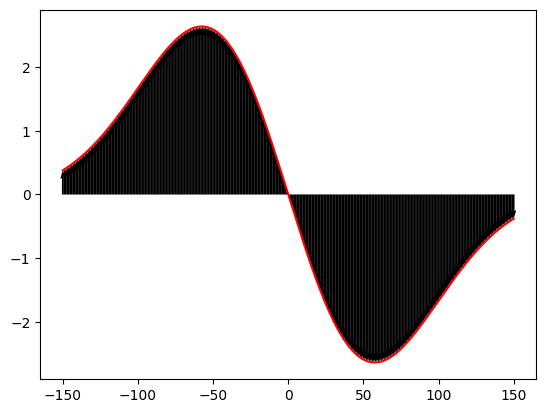

In [10]:
data = pd.DataFrame({'nic': [50], 'njc': [50], 'r': [30]}).iloc[0]*5

x1 = x[data.nic-data.r:data.nic+data.r+1]
y1 = np.array([y[data.njc]] * len(x1))

u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]


plt.quiver(x1, [0]*len(x1), [0]*len(v1), v1, scale_units='xy', scale=1)
plt.plot(x1, v1, color='r') 



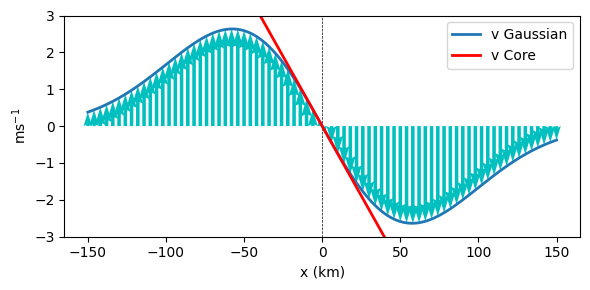

In [11]:
plt.figure(figsize=(6,3))
plt.axvline(x=0, color='k', linewidth=.5, linestyle='--')
plt.plot(x1, v1, linewidth=2, label='v Gaussian')
spac = 4
plt.quiver(x1[::spac], [0]*len(x1[::spac]), [0]*len(v1[::spac]), v1[::spac], scale_units='xy', scale=1, color='c')

vcore = 2*A*q11*(x1-xc) + 2*A*q12*(y1-yc)
plt.plot(x1, vcore, 'r-', linewidth=2, label='v Core')

plt.legend()
plt.xlabel(r'x (km)')
plt.ylabel(r'ms$^{-1}$')
plt.ylim(-3, 3)
plt.tight_layout()


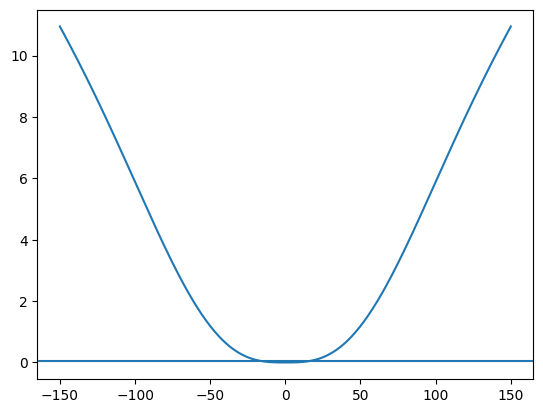

In [12]:
plt.plot(x1, np.abs(vcore-v1))
plt.axhline(y=.05)


In [13]:
def deform_eddy(Q11=1, Q12=0, Q22=1):
    width=500
    x = np.linspace(-width // 2, width // 2, 501)
    y = np.linspace(-width // 2, width // 2, 501)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    xc, yc = 0.0, 0.0

    psi0 = 250
    Rc = 85.0
    A = - psi0 / Rc**2 
    
    # rescale Q to have unit determinant
    Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
    q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]
    
    dx, dy = X - xc, Y - yc
    rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
    Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
    psi = psi0 * np.exp( - rho2 / Rc**2 )
    u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
    v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2

    nic, njc, r = 260, 260, 30
    skip = 10
    x1 = x[nic-r:nic+r+1:skip]
    y1 = np.array([y[njc]] * len(x1))

    u1 = u[nic-r:nic+r+1:skip, njc]
    v1 = v[nic-r:nic+r+1:skip, njc]

    y2 = y[njc-r:njc+r+1:skip]
    x2 = np.array([x[nic]] * len(y2))

    u2 = u[nic, njc-r:njc+r+1:skip]
    v2 = v[nic, njc-r:njc+r+1:skip]

    xc_dop, yc_dop, w_dop, Q_dop, Rc_dop, psi0_dop, A_dop = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, plot_flag=False)
    w_dop *= 1e-6
    
    return xc_dop, yc_dop, w_dop, Q_dop, Rc_dop, psi0_dop, A_dop, q11, q12, q22


df_deform_tests = pd.DataFrame({'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-3], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A], 'Q11': np.nan, 'Q12': np.nan, 'Q22': np.nan})

for Q12 in np.arange(0.0, .8 + 0.05, 0.05):
    xc_dop, yc_dop, w_dop, Q_dop, Rc_dop, psi0_dop, A_dop, Q11, Q12, Q22 = deform_eddy(Q12=Q12)
    df_deform_tests.loc[len(df_deform_tests)] = {'xc': xc_dop, 'yc': yc_dop, 'w': w_dop, 'q11': Q_dop[0,0], 'q12': Q_dop[1,0], 'q22': Q_dop[1,1],
                        'Rc': Rc_dop, 'psi0': psi0_dop, 'A': A_dop, 'Q11': Q11, 'Q12': Q12, 'Q22': Q22}
df_deform_tests = df_deform_tests.iloc[1:]
df_deform_tests




,xc,yc,w,q11,q12,q22,Rc,psi0,A,Q11,Q12,Q22
1,-0.017653,-0.017653,-1.356711e-07,1.000001,-0.001295,1.000001,85.199209,250.979372,-0.034575,1.000000,0.000000,1.000000
2,-0.019628,-0.019628,-1.358081e-07,1.001187,0.048746,1.001187,85.207822,251.023788,-0.034575,1.001252,0.050063,1.001252
3,-0.021669,-0.021669,-1.362912e-07,1.004905,0.099163,1.004905,85.212516,251.046320,-0.034574,1.005038,0.100504,1.005038
4,-0.023802,-0.023802,-1.371321e-07,1.011239,0.150348,1.011239,85.213337,251.047460,-0.034573,1.011443,0.151717,1.011443
5,-0.026056,-0.026056,-1.383512e-07,1.020341,0.202723,1.020341,85.210378,251.028000,-0.034573,1.020621,0.204124,1.020621
6,-0.028466,-0.028466,-1.399791e-07,1.032437,0.256762,1.032437,85.203791,250.989050,-0.034573,1.032796,0.258199,1.032796
7,-0.031074,-0.031074,-1.420586e-07,1.047842,0.313007,1.047842,85.193807,250.932136,-0.034573,1.048285,0.314485,1.048285
8,-0.033936,-0.033936,-1.446485e-07,1.066988,0.372108,1.066988,85.180784,250.859384,-0.034574,1.067521,0.373632,1.067521
9,-0.037118,-0.037118,-1.478279e-07,1.090459,0.434858,1.090459,85.165271,250.773787,-0.034575,1.091089,0.436436,1.091089
10,-0.040713,-0.040713,-1.517047e-07,1.119049,0.502265,1.119049,85.148099,250.679559,-0.034576,1.119785,0.503903,1.119785


In [14]:
df_deform_tests['Err'] = np.hypot(df_deform_tests.xc, df_deform_tests.yc)
# Aspect Ratio
ARs = []
for k in range(len(df_deform_tests)):
    data = df_deform_tests.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.Q11, data.Q12, data.Q22))
df_deform_tests['AR'] = ARs
df_deform_tests


,xc,yc,w,q11,q12,q22,Rc,psi0,A,Q11,Q12,Q22,Err,AR
1,-0.017653,-0.017653,-1.356711e-07,1.000001,-0.001295,1.000001,85.199209,250.979372,-0.034575,1.000000,0.000000,1.000000,0.024965,1.000000
2,-0.019628,-0.019628,-1.358081e-07,1.001187,0.048746,1.001187,85.207822,251.023788,-0.034575,1.001252,0.050063,1.001252,0.027759,1.051315
3,-0.021669,-0.021669,-1.362912e-07,1.004905,0.099163,1.004905,85.212516,251.046320,-0.034574,1.005038,0.100504,1.005038,0.030645,1.105542
4,-0.023802,-0.023802,-1.371321e-07,1.011239,0.150348,1.011239,85.213337,251.047460,-0.034573,1.011443,0.151717,1.011443,0.033661,1.163160
5,-0.026056,-0.026056,-1.383512e-07,1.020341,0.202723,1.020341,85.210378,251.028000,-0.034573,1.020621,0.204124,1.020621,0.036848,1.224745
6,-0.028466,-0.028466,-1.399791e-07,1.032437,0.256762,1.032437,85.203791,250.989050,-0.034573,1.032796,0.258199,1.032796,0.040256,1.290994
7,-0.031074,-0.031074,-1.420586e-07,1.047842,0.313007,1.047842,85.193807,250.932136,-0.034573,1.048285,0.314485,1.048285,0.043946,1.362770
8,-0.033936,-0.033936,-1.446485e-07,1.066988,0.372108,1.066988,85.180784,250.859384,-0.034574,1.067521,0.373632,1.067521,0.047992,1.441153
9,-0.037118,-0.037118,-1.478279e-07,1.090459,0.434858,1.090459,85.165271,250.773787,-0.034575,1.091089,0.436436,1.091089,0.052493,1.527525
10,-0.040713,-0.040713,-1.517047e-07,1.119049,0.502265,1.119049,85.148099,250.679559,-0.034576,1.119785,0.503903,1.119785,0.057577,1.623688


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


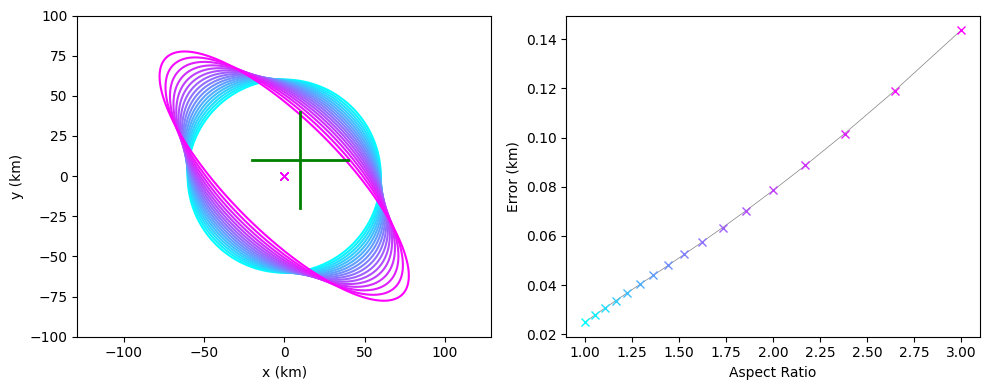

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

N = len(df_deform_tests)
cmap = plt.cm.cool
cols = cmap(np.linspace(0, 1, N))

# ------------------ RIGHT panel (was left) ------------------
axs[1].plot(df_deform_tests.AR, df_deform_tests.Err, lw=.5, color='k', alpha=.5)
for i, (ar, err) in enumerate(zip(df_deform_tests.AR, df_deform_tests.Err)):
    axs[1].plot(ar, err, marker='x', color=cols[i])

axs[1].set_xlabel('Aspect Ratio')
axs[1].set_ylabel('Error (km)')

# ------------------ Grid ------------------
width = 500
x = np.linspace(-width // 2, width // 2, 501)
y = np.linspace(-width // 2, width // 2, 501)
X, Y = np.meshgrid(x, y, indexing='ij')

# ------------------ LEFT panel (was right) ------------------
for i, (q11, q12, q22) in enumerate(zip(df_deform_tests.Q11,
                                      df_deform_tests.Q12,
                                      df_deform_tests.Q22)):
    rho2 = q11*X**2 + 2*q12*X*Y + q22*Y**2

    axs[0].contour(
        X, Y, rho2,
        levels=[Rc**2/2],
        colors=[cols[i]],
        linewidths=1.5
    )

for i, (xc_, yc_) in enumerate(zip(df_deform_tests.xc, df_deform_tests.yc)):
    axs[0].plot(xc_, yc_, marker='x', color=cols[i])

# reference transect
nic_, njc_, r_ = 260, 260, 30
skip = 10
x1 = x[nic_-r_:nic_+r_+1:skip]
y1 = np.array([y[njc_]] * len(x1))
y2 = y[njc_-r_:njc_+r_+1:skip]
x2 = np.array([x[nic_]] * len(y2))
axs[0].plot(x1, y1, color='g', lw=2)
axs[0].plot(x2, y2, color='g', lw=2)

axs[0].axis('equal')
axs[0].set_xlim(-100, 100)
axs[0].set_ylim(-100, 100)
axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')

plt.tight_layout()
